In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0513

/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0513


In [ ]:
!pip install fmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 11.2 MB/s eta 0:00:00


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


SystemError: ignored

In [ ]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from fmpy.util import plot_result, download_test_file
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

import random
import numpy as np
import torch
import argparse
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import scipy.signal
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch import FloatTensor as FT
import tensorflow_probability as tfp

In [ ]:
fmu_filename = 'HEV_TMED_Simulator_Rearrange_230511_linux.fmu'
start_time = 0.0
stop_time = 1800.0
step_size = 0.01
soc_init = 67

# WLTP profile에 대하여 시험
with open("wltp_vehicle_speed_profile_real.csv") as file_name:
    vehicle_speed_profile = np.loadtxt(file_name, delimiter=",")

In [ ]:
class HEV:
    def __init__(self, fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile):
        self.fmu_filename = fmu_filename
        self.vrs = {}
        self.start_time = start_time
        self.stop_time = stop_time
        self.step_size = step_size
        self.time = self.start_time
        self.vehicle_speed_profile = vehicle_speed_profile
        self.soc_init = soc_init/5000
        self.state_init = np.array([self.soc_init, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1,-1)
        self.state = np.array([self.soc_init, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1,-1)
        self.action_upper_bound = 15000
        self.action_lower_bound = -15000
        #self.action_space = [[13500, 2000], [500, 2000], [13500, -15000], [500, -15000]]
        self.obssize = len(self.state[0])
        self.actsize = 2

    def step(self, action):
        #a = self.action_space[action]
#         action = action*self.action_upper_bound
        a1 = action[0]*self.action_upper_bound
        a2 = action[0]*self.action_upper_bound
        a3 = self.soc_init
        a4 = action[1]/2 + 1
        instant_veh_speed = np.interp(self.time, self.vehicle_speed_profile[:,0], self.vehicle_speed_profile[:,1])
        self.fmu.setReal([self.vr_input1, self.vr_input2, self.vr_input3, self.vr_input4, self.vr_input5], [instant_veh_speed, a1, a2, a3, a4]) #input variable, input key(13500 2000)
        self.fmu.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
#         [output1, output2, output3, output4, output5, output6, output7] = self.fmu.getReal([self.vr_output1,self.vr_output2, self.vr_output3, self.vr_output4, self.vr_output5, self.vr_output6, self.vr_output7])
#         self.state = [output1, output2, output3, output4, output5, output6, output7]
        state = np.array(self.fmu.getReal(np.arange(35)))/5000
        state_column = np.array([self.vrs['Bat_SOC'], self.vrs['nEngOn'], self.vrs['PT_tqTmInDmd_Nm_P2'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph'], self.vrs['BSFC_g_kWh[1]']])
        self.state = state[state_column]
        soc = state[self.vrs['Bat_SOC']]
        BSFC = state[self.vrs['BSFC_g_kWh[1]']]
        reward = - 5000*(self.soc_init - soc) ** 2 - 10*BSFC
        is_done = lambda time: time >= self.stop_time
        self.time += self.step_size
        return self.state.reshape(1,-1), reward, is_done(self.time), None

    def reset(self):
        self.state = self.state_init
        model_description = read_model_description(self.fmu_filename)
        for variable in model_description.modelVariables:
            self.vrs[variable.name] = variable.valueReference
        unzipdir = extract(fmu_filename)
        self.fmu = FMU2Slave(guid=model_description.guid,
                       unzipDirectory=unzipdir,
                       modelIdentifier=model_description.coSimulation.modelIdentifier,
                       instanceName='instance1')
        self.fmu.instantiate()
        self.fmu.setupExperiment(startTime=self.start_time)
        self.fmu.enterInitializationMode()
        self.fmu.exitInitializationMode()
        self.time = self.start_time

        self.vr_input1 = self.vrs['Driver_sVeh_Target_kph']
        self.vr_input2 = self.vrs['Engine_on_line']
        self.vr_input3 = self.vrs['Engine_off_line']
        self.vr_input4 = self.vrs['soc_init']
        self.vr_input5 = self.vrs['Engine_OOL']
        self.vr_output1 = self.vrs['TgMod_fPt']
        self.vr_output2 = self.vrs['P2_wElec_W']
        self.vr_output3 = self.vrs['P4_wElec_W']
        self.vr_output4 = self.vrs['ObP2_wElecBIntv_W']
        self.vr_output5 = self.vrs['EV_on_line']
        self.vr_output6 = self.vrs['EV_off_line']
        self.vr_output7 = self.vrs['Bat_SOC']
        self.vr_output8 = self.vrs['PT_tqTmInDmd_Nm_P2']
        self.vr_output9 = self.vrs['P0_wElec_W']
        self.vr_output10 = self.vrs['Pwr_Aux_W']
        self.vr_output11 = self.vrs['ObEng_nEng_Rpm']
        self.vr_output12 = self.vrs['TrEtp_tqEngMAF_Nm']
        self.vr_output13 = self.vrs['rpm_P0']
        self.vr_output14 = self.vrs['TM_F_nTmIn_rpm']
        self.vr_output15 = self.vrs['TM_R_nTmIn_rpm']
        self.vr_output16 = self.vrs['eBat_kWh']
        self.vr_output17 = self.vrs['nEngOn']
        self.vr_output18 = self.vrs['TrP0_tqP0_Nm']
        self.vr_output19 = self.vrs['TrP2_tqP2_Nm']
        self.vr_output20 = self.vrs['TrP4_tqP4_Nm']
        self.vr_output21 = self.vrs['TCU_F_fCurGe']
        self.vr_output22 = self.vrs['TCU_F_fTarGe']
        self.vr_output23 = self.vrs['Driver_sVeh_kph']
        self.vr_output24 = self.vrs['Eng_eff_avg']
        self.vr_output25 = self.vrs['TM_F_P0P2_eff_avg']
        self.vr_output26 = self.vrs['TM_F_P0P4_eff_avg']
        self.vr_output27 = self.vrs['BSFC_g_kWh[1]']
        self.vr_output28 = self.vrs['BSFC_g_kWh[2]']
        self.vr_output29 = self.vrs['BSFC_g_kWh[3]']

        return self.state.reshape(1,-1)

DP

In [ ]:
action_grid = []
for i in np.linspace(-1.0, 1.0, 11):
  for j in np.linspace(-1.0, 1.0, 11):
    action_grid.append((i,j))
action_grid

[(-1.0, -1.0),
 (-1.0, -0.8),
 (-1.0, -0.6),
 (-1.0, -0.3999999999999999),
 (-1.0, -0.19999999999999996),
 (-1.0, 0.0),
 (-1.0, 0.20000000000000018),
 (-1.0, 0.40000000000000013),
 (-1.0, 0.6000000000000001),
 (-1.0, 0.8),
 (-1.0, 1.0),
 (-0.8, -1.0),
 (-0.8, -0.8),
 (-0.8, -0.6),
 (-0.8, -0.3999999999999999),
 (-0.8, -0.19999999999999996),
 (-0.8, 0.0),
 (-0.8, 0.20000000000000018),
 (-0.8, 0.40000000000000013),
 (-0.8, 0.6000000000000001),
 (-0.8, 0.8),
 (-0.8, 1.0),
 (-0.6, -1.0),
 (-0.6, -0.8),
 (-0.6, -0.6),
 (-0.6, -0.3999999999999999),
 (-0.6, -0.19999999999999996),
 (-0.6, 0.0),
 (-0.6, 0.20000000000000018),
 (-0.6, 0.40000000000000013),
 (-0.6, 0.6000000000000001),
 (-0.6, 0.8),
 (-0.6, 1.0),
 (-0.3999999999999999, -1.0),
 (-0.3999999999999999, -0.8),
 (-0.3999999999999999, -0.6),
 (-0.3999999999999999, -0.3999999999999999),
 (-0.3999999999999999, -0.19999999999999996),
 (-0.3999999999999999, 0.0),
 (-0.3999999999999999, 0.20000000000000018),
 (-0.3999999999999999, 0.400000000

In [ ]:
def generate_actionlist(timestep, act):
  action_buffer = {}
  action_array = np.zeros([timestep, len(act)])

  for i in range(timestep):
    action_buffer[i] = list(range(len(act)))
  for j in range(len(act)):
    for i in range(timestep):
      idx = np.random.randint(0,len(act)-j)
      idx = action_buffer[i][idx]
      action_array[i][j] = idx
      action_buffer[i].remove(idx)
  return action_array
    # print('{0}, {1}'.format(i, j))
# print(action_buffer)

In [ ]:
def policy_evaluation(value_array,timestep, action_grid, iter_num, dis=0.8):
  # if iter_num == 0:
  #   print('Iteration: {} \n{}\n'.format(iter_num, post_value_table))
  #   return post_value_table

  # value_array = np.zeros([timestep, len(action_grid)], dtype = float)


  for iteration in range(iter_num):
    # next_value_table = np.zeros([timestep, 1], dtype=float)
    for i in range(len(action_grid)):
      env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
      env.reset()
      for j in range(timestep):
        action_idx = int(action_array[j,i])
        s,r,done,_ = env.step(action_grid[action_idx])
        value_array[j,action_idx] = r + dis*value_array[j,action_idx]
    # iteration += 1
      print('{} complete'.format(i))

    # print('Iteration: {} \n{}\n'.format(iteration, next_value_table))
    # print('---------------------------------------------------------------------------------------------------------')

    # if (iteration % 10) != iter_num:
    #         # print result
    #         if iteration > 100 :
    #             if (iteration % 20) == 0:
    #                 print('Iteration: {} \n{}\n'.format(iteration, next_value_table))
    #         else :
    #             if (iteration % 10) == 0:
    #                 print('Iteration: {} \n{}\n'.format(iteration, next_value_table))
    # else :
    #   print('Iteration: {} \n{}\n'.format(iteration, next_value_table ))

    post_value_table = value_array

  return value_array


In [ ]:
action_array = generate_actionlist(180000,action_grid)
action_array.shape

(180000, 121)

In [ ]:
# table = np.zeros([180000, len(action_grid)], dtype = float)
data = pd.read_csv('./valuetable/value_4.csv')
table = data.to_numpy()
table

array([[-2.76411802, -2.76411802, -2.76411802, ..., -2.76411802,
        -2.76411802, -2.76411802],
       [-2.76411802, -2.76411802, -2.76411802, ..., -2.76411802,
        -2.76411802, -2.76411802],
       [-2.76411778, -2.76411778, -2.76411778, ..., -2.76411778,
        -2.76411778, -2.76411778],
       ...,
       [-0.79825639, -0.79641924, -0.8206968 , ..., -0.80287624,
        -0.79485241, -0.80518676],
       [-0.78819591, -0.82459547, -0.79450059, ..., -0.79242767,
        -0.79513327, -0.79974147],
       [-0.81270627, -0.80614504, -0.78727969, ..., -0.79338626,
        -0.80068868, -0.79699873]])

In [ ]:
start = time.time()
value = policy_evaluation(table, 180000, action_grid, 1)
print(time.time()-start)

df = pd.DataFrame(value)
filename = 'value_5.csv'
df.to_csv('./valuetable/'+filename, index=False)

# 이거 max 뽑아서 돌리고 reward 해보자

0 complete
1 complete
2 complete
3 complete
4 complete
5 complete
6 complete
7 complete
8 complete
9 complete
10 complete
11 complete
12 complete
13 complete
14 complete
15 complete
16 complete
17 complete
18 complete
19 complete
20 complete
21 complete
22 complete
23 complete
24 complete
25 complete
26 complete
27 complete
28 complete
29 complete
30 complete
31 complete
32 complete
33 complete
34 complete
35 complete
36 complete
37 complete
38 complete
39 complete
40 complete
41 complete
42 complete
43 complete
44 complete
45 complete
46 complete
47 complete
48 complete
49 complete
50 complete
51 complete
52 complete
53 complete
54 complete
55 complete
56 complete
57 complete
58 complete
59 complete
60 complete
61 complete
62 complete
63 complete
64 complete
65 complete
66 complete
67 complete
68 complete
69 complete
70 complete
71 complete
72 complete
73 complete
74 complete
75 complete
76 complete
77 complete
78 complete
79 complete
80 complete
81 complete
82 complete
83 complete
84

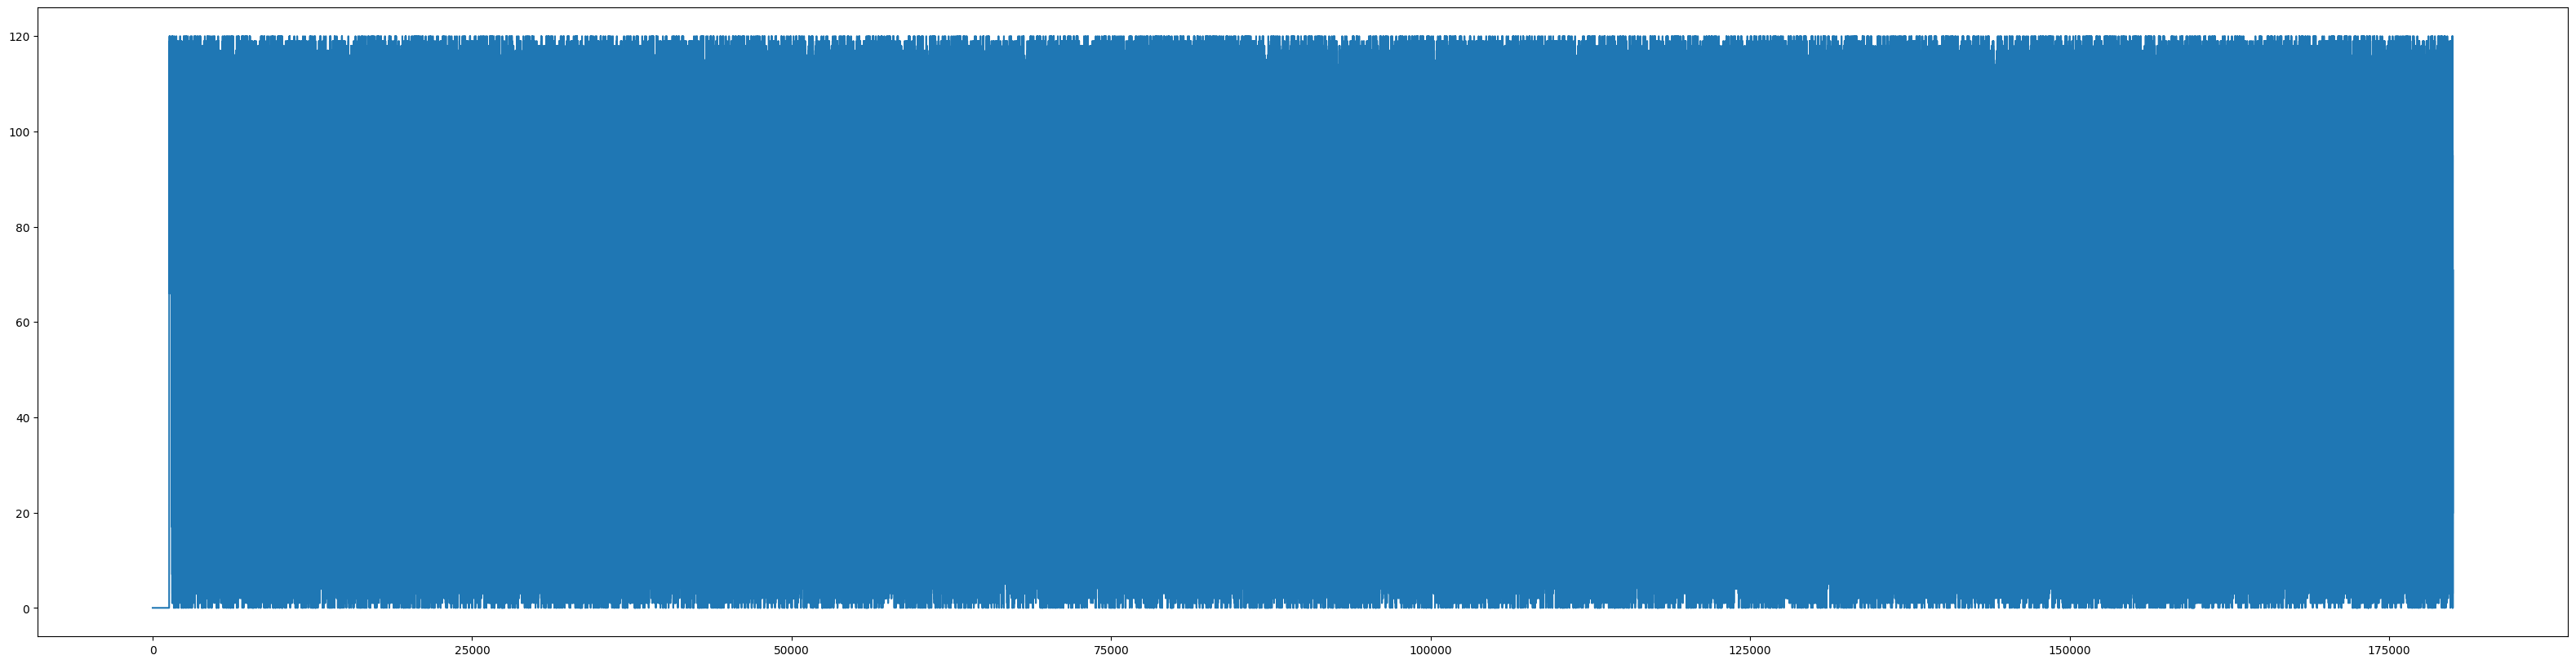

[103  33   1  15  60   6  28 100  14  75  36  78   5  22  10  69  33  82
  86   9  48  17  47  87  26  27  45  34 108 110  27  77 101  51  74  55
  65  19  64  27  36 104  17  25 120 118   4  21  41  46  85 108  55  54
   9  93 111   1  61  68  41  65  91  98  97  91  29  87  28   0  38 113
  86   2   1 120  37   0  79  28 105  78  42  40  91  66   7  96   3  67
  95  40   5  73  87  18   0  71  68  20]


In [ ]:
plt.figure(figsize=(40,10))
plt.plot(np.argmax(value,axis=1))
plt.show()
print(np.argmax(value,axis=1)[-100:])

0 complete
1 complete
2 complete
3 complete
4 complete


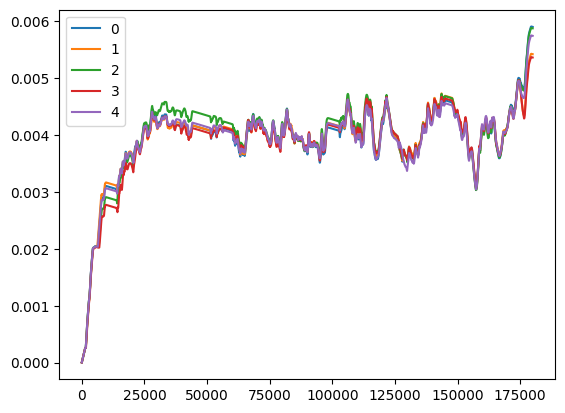

In [ ]:
for j in range(5):
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  env.reset()
  state = []
  for i in range(180000):
    idx = np.random.randint(0,len(action_grid))
    s,r,done,_ = env.step(action_grid[idx])
    state.append(s[0][0])
  print('{} complete'.format(j))
  plt.plot(state,label = j)
plt.legend()
plt.show()

0
16.371445417404175
total reward: -125165.56724149767
1
31.28688931465149
total reward: -124154.52268060751
2
47.95068287849426
total reward: -124269.54072853494
3
63.44692945480347
total reward: -124597.05027305412
4
78.97475838661194
total reward: -124492.31884351853


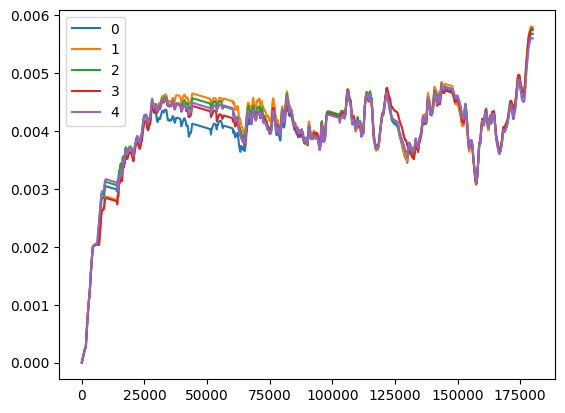

In [ ]:
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
env.reset()

done = False
cum_reward = 0.0
action = np.array([1,1])
start = time.time()
simulink_r = []
simulink_s = []
simulink_a = []
t = 0

for i in range(5):
  env.reset()
  done = False
  cum_reward = 0.0
  simulink_r = []
  simulink_s = []
  simulink_a = []
  t=0
  while not done:
    # if t<100000:
      # action = np.array([0,0])
    # else:

    action = np.array(action_grid[np.random.randint(0,len(action_grid)-1)])
    t += 1
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    simulink_r.append(reward)
    simulink_s.append(state[0][0])
    simulink_a.append(action)
  print(i)
  print(time.time()-start)
  print(f"total reward: {cum_reward}")
  plt.plot(simulink_s, label=i)
plt.legend()
plt.show()

DDPG

In [ ]:
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
num_states = 9
num_actions = 2
upper_bound = 1.0
lower_bound = -1.0

In [ ]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [ ]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,step
    ):


        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))


        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

        return [critic_loss,actor_loss]

    # We compute the loss and update parameters
    def learn(self,step):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        a = self.update(state_batch, action_batch, reward_batch, next_state_batch,step)
        return a



# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [ ]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(2, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    # outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

def policy(state,noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)

In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.01

buffer = Buffer(50000, 64)

In [ ]:
rm -rf ./runs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./runs

In [ ]:
# 학습이 잘 되고 있는지 평가할 지표 (모델의 평가지표 아님) (ex epoch마다)
# 학습 데이터 (speed profile)

# # To store reward history of each episode
# ep_reward_list = []
# # To store average reward history of last few episodes
# avg_reward_list = []



env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
start = time.time()
# r_total = []
# a_total = []

sess = tf.compat.v1.Session()
# Takes about 4 min to train
for ep in range(total_episodes):
    r_record = []
    a_record = []

    done = False

    i=0

    prev_state = env.reset()
    # episodic_reward = 0
    # print('########################## ep : {} ############################'.format(ep))

    train_summary_writer = tf.summary.create_file_writer(f'./runs/({ep})')
    # test_summary_writer = tf.summary.create_file_writer(test_log_dir)

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.convert_to_tensor(prev_state)

        action = policy(tf_prev_state,ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        # episodic_reward += reward

        b = buffer.learn(i)
        # if i%10 == 0:
          # print('----------------------------------------------------------------')
          # print('critic loss : {}'.format(b[0].numpy()))
          # print('actor loss  : {}'.format(b[1].numpy()))

        with train_summary_writer.as_default():
          tf.summary.scalar('critic_loss',b[0].numpy(),step = i)
          tf.summary.scalar('actor_loss',b[1].numpy(),step = i)
          # tf.summary.scalar('total reward',episodic_reward,step = i)
          # tf.summary.scalar('Battery SOC',state[0][0],step = i)

        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        r_record.append(reward)
        a_record.append(action)


        # End this episode when `done` is True
        if done:
            break

        if i%1000==0:
          print('----------------------------------------------------------------')
          print('i : {}'.format(i))
          print('state : {}'.format(state))
          print('action : {}'.format(action))
          print('----------------------------------------------------------------')

        prev_state = state
        i+=1

    r_record = np.array(r_record)
    a_record = np.array(a_record)
    # r_total.append(r_record)
    # a_total.append(a_record)

    # ep_reward_list.append(episodic_reward)

    # # Mean of last 40 episodes
    # avg_reward = np.mean(ep_reward_list[-40:])
    # print("Episode * {} * Total Reward is ==> {}".format(ep, np.sum(r_record)))
    # avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards

# plt.plot(np.mean(r_total))
# plt.xlabel("Episode")
# plt.ylabel("Avg. Epsiodic Reward")

# print('Avg reward is {}'.format(np.sum(r_total)/total_episodes))
print(time.time()-start)
# plt.show()
train_summary_writer.close()

----------------------------------------------------------------
i : 0
state : [[ 2.68e-06  0.00e+00  0.00e+00  8.00e-02  0.00e+00 -2.00e-04  0.00e+00
   0.00e+00  0.00e+00]]
action : [-0.02777277 -0.02777484]
----------------------------------------------------------------


# Test

In [ ]:
class HEV:
    def __init__(self, fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile):
        self.fmu_filename = fmu_filename
        self.vrs = {}
        self.start_time = start_time
        self.stop_time = stop_time
        self.step_size = step_size
        self.time = self.start_time
        self.vehicle_speed_profile = vehicle_speed_profile
        self.soc_init = soc_init/5000
        self.state_init = np.array([self.soc_init, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1,-1)
        self.state = np.array([self.soc_init, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1,-1)
        self.action_upper_bound = 15000
        self.action_lower_bound = -15000
        #self.action_space = [[13500, 2000], [500, 2000], [13500, -15000], [500, -15000]]
        self.obssize = len(self.state[0])
        self.actsize = 2

    def step(self, action):
        #a = self.action_space[action]
#         action = action*self.action_upper_bound
        a1 = action[0]*self.action_upper_bound
        a2 = action[0]*self.action_upper_bound
        a3 = self.soc_init
        a4 = action[1]/2 + 1
        instant_veh_speed = np.interp(self.time, self.vehicle_speed_profile[:,0], self.vehicle_speed_profile[:,1])
        self.fmu.setReal([self.vr_input1, self.vr_input2, self.vr_input3, self.vr_input4, self.vr_input5], [instant_veh_speed, a1, a2, a3, a4]) #input variable, input key(13500 2000)
        self.fmu.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
#         [output1, output2, output3, output4, output5, output6, output7] = self.fmu.getReal([self.vr_output1,self.vr_output2, self.vr_output3, self.vr_output4, self.vr_output5, self.vr_output6, self.vr_output7])
#         self.state = [output1, output2, output3, output4, output5, output6, output7]
        state = np.array(self.fmu.getReal(np.arange(35)))/5000
        state_column = np.array([self.vrs['Bat_SOC'], self.vrs['nEngOn'], self.vrs['PT_tqTmInDmd_Nm_P2'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph'], self.vrs['BSFC_g_kWh[1]']])
        self.state = state[state_column]
        soc = state[self.vrs['Bat_SOC']]
        BSFC = state[self.vrs['BSFC_g_kWh[1]']]
        reward = - 5000*(self.soc_init - soc) ** 2 - 10*BSFC
        is_done = lambda time: time >= self.stop_time
        self.time += self.step_size
        return self.state.reshape(1,-1), reward, is_done(self.time), None

    def reset(self):
        self.state = self.state_init
        model_description = read_model_description(self.fmu_filename)
        for variable in model_description.modelVariables:
            self.vrs[variable.name] = variable.valueReference
        unzipdir = extract(fmu_filename)
        self.fmu = FMU2Slave(guid=model_description.guid,
                       unzipDirectory=unzipdir,
                       modelIdentifier=model_description.coSimulation.modelIdentifier,
                       instanceName='instance1')
        self.fmu.instantiate()
        self.fmu.setupExperiment(startTime=self.start_time)
        self.fmu.enterInitializationMode()
        self.fmu.exitInitializationMode()
        self.state = self.state_init
        self.time = self.start_time

        self.vr_input1 = self.vrs['Driver_sVeh_Target_kph']
        self.vr_input2 = self.vrs['Engine_on_line']
        self.vr_input3 = self.vrs['Engine_off_line']
        self.vr_input4 = self.vrs['soc_init']
        self.vr_input5 = self.vrs['Engine_OOL']
        self.vr_output1 = self.vrs['TgMod_fPt']
        self.vr_output2 = self.vrs['P2_wElec_W']
        self.vr_output3 = self.vrs['P4_wElec_W']
        self.vr_output4 = self.vrs['ObP2_wElecBIntv_W']
        self.vr_output5 = self.vrs['EV_on_line']
        self.vr_output6 = self.vrs['EV_off_line']
        self.vr_output7 = self.vrs['Bat_SOC']
        self.vr_output8 = self.vrs['PT_tqTmInDmd_Nm_P2']
        self.vr_output9 = self.vrs['P0_wElec_W']
        self.vr_output10 = self.vrs['Pwr_Aux_W']
        self.vr_output11 = self.vrs['ObEng_nEng_Rpm']
        self.vr_output12 = self.vrs['TrEtp_tqEngMAF_Nm']
        self.vr_output13 = self.vrs['rpm_P0']
        self.vr_output14 = self.vrs['TM_F_nTmIn_rpm']
        self.vr_output15 = self.vrs['TM_R_nTmIn_rpm']
        self.vr_output16 = self.vrs['eBat_kWh']
        self.vr_output17 = self.vrs['nEngOn']
        self.vr_output18 = self.vrs['TrP0_tqP0_Nm']
        self.vr_output19 = self.vrs['TrP2_tqP2_Nm']
        self.vr_output20 = self.vrs['TrP4_tqP4_Nm']
        self.vr_output21 = self.vrs['TCU_F_fCurGe']
        self.vr_output22 = self.vrs['TCU_F_fTarGe']
        self.vr_output23 = self.vrs['Driver_sVeh_kph']
        self.vr_output24 = self.vrs['Eng_eff_avg']
        self.vr_output25 = self.vrs['TM_F_P0P2_eff_avg']
        self.vr_output26 = self.vrs['TM_F_P0P4_eff_avg']
        self.vr_output27 = self.vrs['BSFC_g_kWh[1]']
        self.vr_output28 = self.vrs['BSFC_g_kWh[2]']
        self.vr_output29 = self.vrs['BSFC_g_kWh[3]']

        return self.state.reshape(1,-1)

In [ ]:
fmu_filename = 'HEV_TMED_Simulator_Rearrange_230511_linux.fmu'
start_time = 0.0
stop_time = 1800.0
step_size = 0.01
soc_init = 67

# WLTP profile에 대하여 시험
with open("wltp_vehicle_speed_profile_real.csv") as file_name:
    vehicle_speed_profile = np.loadtxt(file_name, delimiter=",")

FileNotFoundError: ignored

In [ ]:
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
env.reset()

done = False
cum_reward = 0.0

start = time.time()
r_record = []
s_record = []
t = 0
while not done:
    t += 1
    state, reward, done, _ = env.step(np.array([1,1]))
    cum_reward += reward
    r_record.append(reward)
    s_record.append(state)
print(time.time()-start)
print(f"total reward: {cum_reward}") #-108795.71323956137

NameError: ignored